# Sentiment Analysis using LGBM & MLFlow exp

## Введение

В этом ноутбуке мы используем датасет Amazon Review, препроцессинг данных, трансформацию типа Bag of Words (BoW)

В дальнейшем производим тренировку на LGBM. 

In [1]:
import pandas as pd
import mlflow
import numpy as np
import re
import nltk
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from numpy import triu
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/anatoly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anatoly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Preprocessing function
def preprocess_text(text):
    text = str(text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    # Removing punctuation
    tokens = [token for token in tokens if re.match(r'^\w+$', token)]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

## Импорт данных. Величина датасета - 500 000 (для тренировки)

In [3]:
df_original_train = pd.read_csv("/home/anatoly/Рабочий стол/MLOps/example/Amazon review/amazon_review_polarity_csv/train.csv",header=None, names=("polarity", "title", "text"))
df_train = df_original_train.sample(500000)

In [4]:
df_original_test = pd.read_csv("/home/anatoly/Рабочий стол/MLOps/example/Amazon review/amazon_review_polarity_csv/test.csv", header=None, names=("polarity", "title", "text"))
df_test = df_original_test

In [5]:
# df_train = df_original_train.sample(1000000)
df_train.head()

polarity                                              title  \
2723690         1                                     happy customer   
889620          1                They were right - not XP compatible   
3061069         1                          They only want your money   
740850          2  Wonderful storyteller, engrossing book once yo...   
2254306         1                                  Ours Broke Easily   

                                                      text  
2723690  Mine went out within one year of purchase. Mak...  
889620   Even after reading about issues with XP from o...  
3061069  I really don't have much to comment on the pro...  
740850   Although I read the reviews, this is the first...  
2254306  My daughter got this for Christmas this year a...

In [6]:
df_test.head()

polarity                                              title  \
0         2                                           Great CD   
1         2  One of the best game music soundtracks - for a...   
2         1                   Batteries died within a year ...   
3         2              works fine, but Maha Energy is better   
4         2                       Great for the non-audiophile   

                                                text  
0  My lovely Pat has one of the GREAT voices of h...  
1  Despite the fact that I have only played a sma...  
2  I bought this charger in Jul 2003 and it worke...  
3  Check out Maha Energy's website. Their Powerex...  
4  Reviewed quite a bit of the combo players and ...

In [7]:
df_test.shape

(400000, 3)

## Data Pre-Processing

In [8]:
df_train["clean_text"] = df_train["title"] + " " + df_train["text"]
df_train["clean_text"] = df_train["clean_text"].apply(preprocess_text)
df_train.head()

polarity                                              title  \
2723690         1                                     happy customer   
889620          1                They were right - not XP compatible   
3061069         1                          They only want your money   
740850          2  Wonderful storyteller, engrossing book once yo...   
2254306         1                                  Ours Broke Easily   

                                                      text  \
2723690  Mine went out within one year of purchase. Mak...   
889620   Even after reading about issues with XP from o...   
3061069  I really don't have much to comment on the pro...   
740850   Although I read the reviews, this is the first...   
2254306  My daughter got this for Christmas this year a...   

                                                clean_text  
2723690  happi custom mine went within one year purchas...  
889620   right xp compat even read issu xp review decid...  
3061069  want money realli much comment product seem an...  
740850   wonder storytel engross book give chanc althou...  
2254306  broke easili daughter got christma year almost...

In [9]:
df_test["clean_text"] = df_test["title"] + " " + df_test["text"]
df_test["clean_text"] = df_test["clean_text"].apply(preprocess_text)
df_test.head()

polarity                                              title  \
0         2                                           Great CD   
1         2  One of the best game music soundtracks - for a...   
2         1                   Batteries died within a year ...   
3         2              works fine, but Maha Energy is better   
4         2                       Great for the non-audiophile   

                                                text  \
0  My lovely Pat has one of the GREAT voices of h...   
1  Despite the fact that I have only played a sma...   
2  I bought this charger in Jul 2003 and it worke...   
3  Check out Maha Energy's website. Their Powerex...   
4  Reviewed quite a bit of the combo players and ...   

                                          clean_text  
0  great cd love pat one great voic gener listen ...  
1  one best game music soundtrack game realli pla...  
2  batteri die within year bought charger jul 200...  
3  work fine maha energi better check maha energi...  
4  great review quit bit combo player hesit due u...

## Split X & Y

In [10]:
X_train = df_train["clean_text"]
y_train = df_train["polarity"]

X_test = df_test["clean_text"]
y_test = df_test["polarity"]

### TF-IDF Vectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
X_train_tf2 = tfidf2.fit_transform(X_train)
X_test_tf2 = tfidf2.transform(X_test)

/home/anatoly/anaconda3/envs/mlflow/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


2024/05/19 12:53:49 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



[LightGBM] [Info] Number of positive: 250033, number of negative: 249967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 106.539188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864608
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 20917
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500066 -> initscore=0.000264
[LightGBM] [Info] Start training from score 0.000264


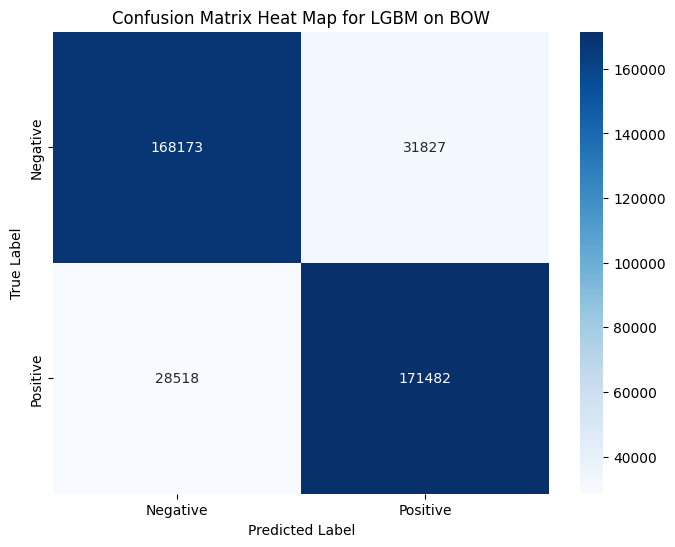

: 

In [12]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
# Зафиксируем текущее название эксперимента
embeddings_experiment = mlflow.set_experiment("LR_bow")

# Зафиксируем название текущего запуска, если не фиксировать, оно автосгенерируется
bow_run_name = "lgbm_bow"
random_state = 42
lgbm_bow_params = {
    # "max_iter": X_train_bow.shape[0]
}

with mlflow.start_run(run_name=bow_run_name) as run:
    model_params = {
        # "multi_class": "multinomial",
        # "solver": "saga",
        "random_state": random_state,
    }
    lgbm_bow = LGBMClassifier()
    lgbm_bow.fit(X_train_tf2, y_train)
    lgbm_predicts = lgbm_bow.predict(X_test_tf2)
    report = classification_report(y_test, lgbm_predicts, output_dict=True)

    # логирование метрик из classification report
    mlflow.log_metric("accuracy", report.pop("accuracy"))
    for class_or_avg, metrics_dict in report.items():
        if class_or_avg == 'macro avg':
            break
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric, value)
    
    # Логирование параметров модели
    mlflow.log_params(lgbm_bow_params) 
    mlflow.log_params(model_params)

    # Логирование целой модели для переиспользование
    mlflow.sklearn.log_model(
        sk_model=lgbm_bow, 
        # input_example=test_features[:10], 
        artifact_path=f"mlflow/{bow_run_name}/model"
    )
    
     # Получение confusion matrix на два класса


    bow_lgbm = confusion_matrix(y_test, lgbm_predicts)
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(bow_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heat Map for LGBM on BOW')
    plt.show()
    
    # Логирование фигур или целых артефактов
    mlflow.log_figure(fig, f'{bow_run_name}_confusion_matrix.png')